In [0]:
display(dbutils.fs.ls("/mnt/raw/prime"))

path,name,size,modificationTime
dbfs:/mnt/raw/prime/numbers.txt,numbers.txt,98887347,1725416668000


In [0]:
from pyspark.sql import SparkSession
import time

# Use the existing SparkSession
spark = SparkSession.builder.appName("DatabricksPrimeTest").getOrCreate()
sc = spark.sparkContext

n_workers = 4  # Number of workers (adjust according to your Databricks cluster configuration)
partition_multiples = range(1, 81, 1)  # Range of partition multiples (1 to 80)

from math import sqrt, ceil

def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, ceil(sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True

# Path to the numbers file and output path in DBFS
numbers_file = "dbfs:/mnt/raw/prime/numbers.txt"
csv_file_path = "dbfs:/mnt/exectime/prime/execution_prime.csv"

# Create a list to store the results
results = []

for num_partitions in partition_multiples:
    # Start the timer
    start_time = time.time()

    # Load the numbers and process them
    numbers_rdd = sc.textFile(numbers_file)
    numbers_rdd = numbers_rdd.repartition(num_partitions)  # Set the number of partitions
    numbers_rdd = numbers_rdd.map(lambda x: int(x))
    prime_numbers_rdd = numbers_rdd.filter(is_prime)
    prime_numbers_rdd.count()

    # End the timer
    end_time = time.time()
    interval = end_time - start_time

    # Get the number of executors
    sc_java = sc._jsc.sc()
    n_executors = len([executor.host() for executor in sc_java.statusTracker().getExecutorInfos()]) - 1

    # Log the results
    results.append((interval, n_workers, n_executors, num_partitions, spark.conf.get("spark.executor.cores", "default"), spark.conf.get("spark.executor.memory", "default")))

    print(f"Execution time with {num_partitions} partitions: {interval} seconds")
    print(f"Executor count (excluding driver): {n_executors}")

# Convert results to a Spark DataFrame and save as a CSV file in DBFS
results_df = spark.createDataFrame(results, schema=["Execution_Time_s", "Number_of_Workers", "Number_of_Executors", "Number_of_Partitions", "Executor_Cores", "Executor_Memory"])
results_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(csv_file_path)

print(f"Statistics saved to {csv_file_path}")


Execution time with 1 partitions: 390.69496512413025 seconds
Executor count (excluding driver): 4
Execution time with 2 partitions: 199.13701462745667 seconds
Executor count (excluding driver): 4
Execution time with 3 partitions: 145.03214716911316 seconds
Executor count (excluding driver): 4
Execution time with 4 partitions: 109.34245729446411 seconds
Executor count (excluding driver): 4
Execution time with 5 partitions: 87.93135571479797 seconds
Executor count (excluding driver): 4
Execution time with 6 partitions: 77.08361506462097 seconds
Executor count (excluding driver): 4
Execution time with 7 partitions: 65.94456267356873 seconds
Executor count (excluding driver): 4
Execution time with 8 partitions: 59.83191180229187 seconds
Executor count (excluding driver): 4
Execution time with 9 partitions: 54.11611032485962 seconds
Executor count (excluding driver): 4
Execution time with 10 partitions: 49.82814574241638 seconds
Executor count (excluding driver): 4
Execution time with 11 pa

In [0]:
results_df[results_df.Number_of_Partitions %4 == 0]

,Execution_Time_s,Number_of_Workers,Number_of_Executors,Number_of_Partitions,Executor_Cores,Executor_Memory
3,109.342457,4,4,4,default,7284m
7,59.831912,4,4,8,default,7284m
11,44.646400,4,4,12,default,7284m
15,37.118043,4,4,16,default,7284m
19,48.202127,4,4,20,default,7284m
23,42.822844,4,4,24,default,7284m
27,38.920986,4,4,28,default,7284m
31,37.036112,4,4,32,default,7284m
35,42.191465,4,4,36,default,7284m
39,39.561953,4,4,40,default,7284m


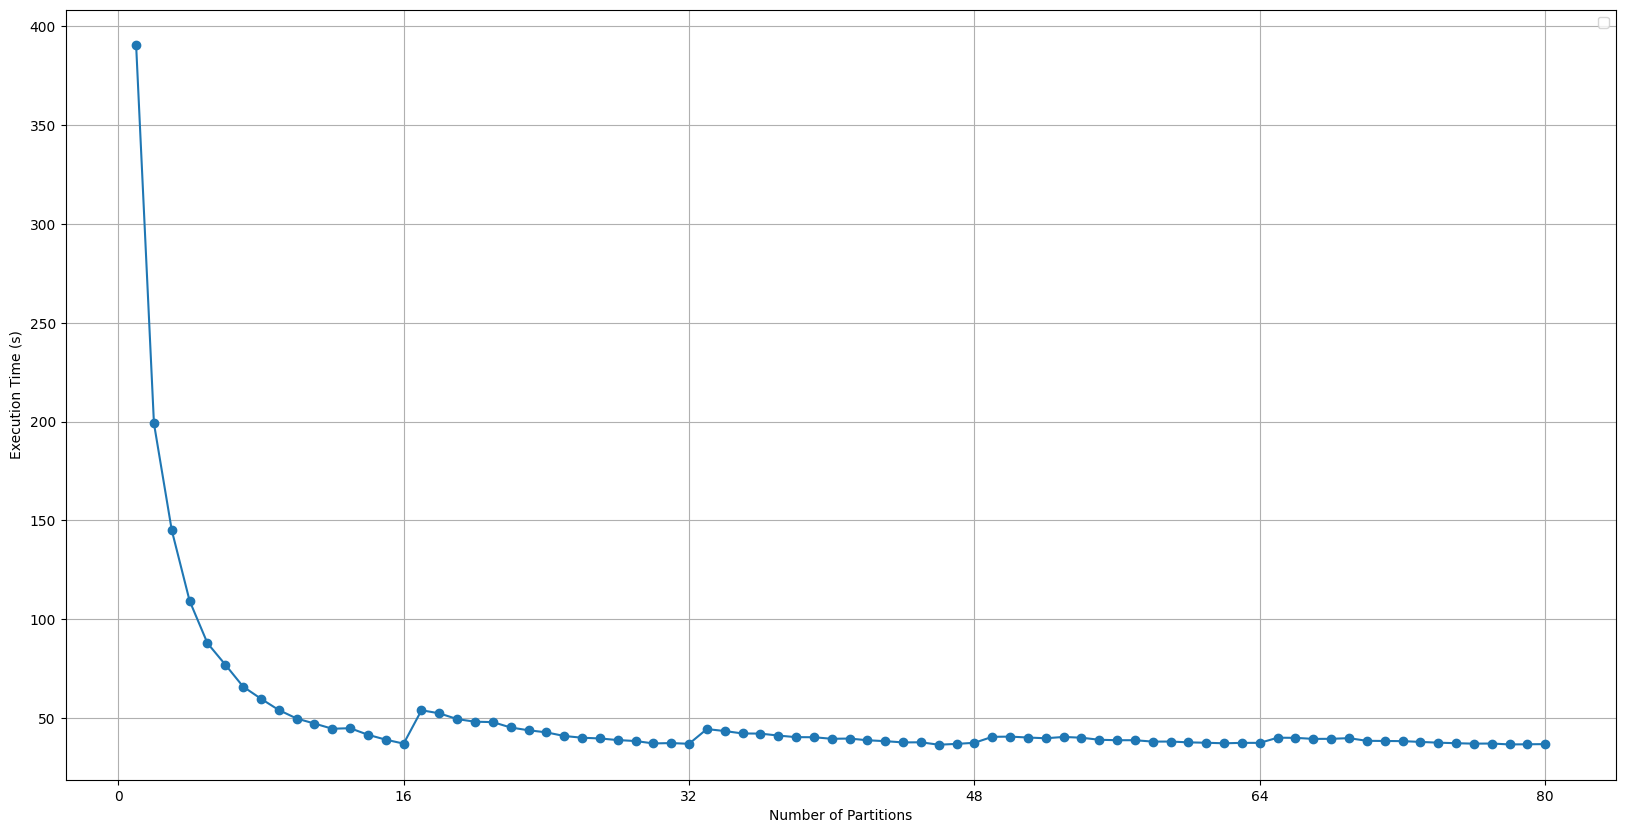

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Convert results to a Pandas DataFrame
results_df = pd.DataFrame(results, columns=["Execution_Time_s", "Number_of_Workers", "Number_of_Executors", "Number_of_Partitions", "Executor_Cores", "Executor_Memory"])
xticks = np.arange(0, 81,16)

plt.figure(figsize=(20, 10))
plt.plot(results_df["Number_of_Partitions"], results_df['Execution_Time_s'], marker='o')
plt.xlabel('Number of Partitions')
plt.ylabel('Execution Time (s)')
plt.grid(True)
plt.xticks(xticks)
plt.legend()
plt.show()

In [0]:
from pyspark.sql import SparkSession
import time

# Use the existing SparkSession
spark = SparkSession.builder.appName("DatabricksPrimeTestOnePartition").getOrCreate()
sc = spark.sparkContext

# Number of workers (adjust according to your Databricks cluster configuration)
n_workers = 4

from math import sqrt, ceil

def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, ceil(sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True

# Path to the numbers file in DBFS
numbers_file = "dbfs:/mnt/raw/prime/numbers_large.txt"
# Path to save the results as a CSV in DBFS
# csv_file_path = "dbfs:/mnt/exectime/prime/execution_prime_one_partition.csv"

# Run the experiment with 1 partition
num_partitions = 48

# Start the timer
start_time = time.time()

# Load the numbers and process them with 1 partition
numbers_rdd = sc.textFile(numbers_file)
numbers_rdd = numbers_rdd.repartition(num_partitions)  # Set the number of partitions to 1
numbers_rdd = numbers_rdd.map(lambda x: int(x))
prime_numbers_rdd = numbers_rdd.filter(is_prime)
prime_numbers_rdd.count()

# End the timer
end_time = time.time()
interval = end_time - start_time

# Get the number of executors
sc_java = sc._jsc.sc()
n_executors = len([executor.host() for executor in sc_java.statusTracker().getExecutorInfos()]) - 1

# Log the results
results = [(interval, n_workers, n_executors, num_partitions, spark.conf.get("spark.executor.cores", "default"), spark.conf.get("spark.executor.memory", "default"))]

# Convert results to a Spark DataFrame and save as a CSV file in DBFS
# results_df = spark.createDataFrame(results, schema=["Execution_Time_s", "Number_of_Workers", "Number_of_Executors", "Number_of_Partitions", "Executor_Cores", "Executor_Memory"])
# results_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(csv_file_path)

print(f"Execution time with {num_partitions} partition: {interval} seconds")
# print(f"Statistics saved to {csv_file_path}")


Execution time with 48 partition: 359.25651383399963 seconds
